In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr 
import scipy.optimize as sco
import scipy.stats as si 
import time
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

In [2]:
# Parameter Input
S0 = 100.0 # ini stock price
G = 100.0 # garantee level
T = 10 # maturity
m = 0.02 # R&E fee
me = 0.01651366493609785 # rider charge
N, X = 1024, 7.5 # FST param.
I, M = 1000000, 10 # Monte Carlo param.

r = [0.04, 0.01] # risk-free interest rate
# drift = [0.05, 0.02] # drift
sigma = [0.1, 0.2] # volatility
lamb = [0.1, 0.2]
mu = [0.2, -0.1] # jump mean
nu = [0.1, 0.2] # jump volatility

A = np.array([[-0.4, 0.4], [0.3, -0.3]]) # transition matrix
Pi = np.array([[0.9999], [0.0001]]) # ini state

In [3]:
np.exp(mu[0] + 0.5 * nu[0] ** 2) - 1

0.2275250649631777

In [4]:
np.exp(mu[1] + 0.5 * nu[1] ** 2) - 1

-0.07688365361336424

In [5]:
# PV of Zero-coupon bond
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return float(Z)
# Rho1 of Zero-coupon bond
def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100
    return float(Z)
# Rho2 of Zero-coupon bond
def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100
    return float(Z)
print('z(10) = %.16f' % z(r, T, A, Pi)) # 0.7784180374597731
print('rho1_z(10) = %.16f' % rho1_z(r, T, A, Pi)) # -0.0778336802081909
print('rho2_z(10) = %.16f' % rho2_z(r, T, A, Pi)) # -0.0000081235377864

z(10) = 0.7784180374597731
rho1_z(10) = -0.0778336802081909
rho2_z(10) = -0.0000081235377864


In [6]:
# Stochastic Motality Risk
def b(t):
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    B = (1 - np.exp(b * t)) / (c + d * np.exp(b * t))
    return B
def s(t):
    ini = 0.00495 # aged 50 years old in 2017
    # ini = 0.01164 # aged 60 years old in 2017
    # ini = 0.02255 # aged 70 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    # A = 0
    # S_feller = np.exp(A + B(t)*ini)
    S = np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
    return S
print('s(0) = %.16f' % s(0)) # 1.0
print('s(10) = %.16f' % s(15)) # 0.8672053048004046

s(0) = 1.0000000000000000
s(10) = 0.8672053048004046


In [8]:
def rsmjd_gmmb_mc(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, M, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))
    F[0] = S0
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t:
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            J1 = 0
            Nt1 = npr.poisson(lamb1 * tau1)
            if Nt1 > 0:
                for j1 in range(Nt1):
                    J1 = J1 + npr.normal(mu1, nu1)
            J2 = 0
            Nt2 = npr.poisson(lamb2 * (t - tau1))
            if Nt2 > 0:
                for j2 in range(Nt2):
                    J2 = J2 + npr.normal(mu2, nu2)
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + drift1 * tau1 + drift2 * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2) + J1 + J2
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * me * s(t)
            else:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))
    Gmmb = np.mean(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    return (np.mean(cf[-1]), Gmmb)

start = time.clock()
Results = rsmjd_gmmb_mc(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, M, I)
print('Put_MC = %.16f' % Results[0]) # 15.8974221895861056
print('GMMB_MC = %.16f' % Results[1]) # 0.0358920927391137
elapsed = (time.clock() - start)
print("Time used:", elapsed)

Put_MC = 15.8974221895861056
GMMB_MC = 0.0358920927391137
Time used: 372.7311715000001


In [7]:
def rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    p1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    p2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, p1)
    f2 = interpolate.PchipInterpolator(ST, p2)
    P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(P) # 15.8587171702497667
print('Put_FST = %.16f' % rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Put_FST = 15.8587171702497667


In [8]:
def rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    P = rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = s(T) * P - Re
    return float(Loss)  # 1.8689340622882540
start = time.clock()
print('GMMB_FST = %.16f' % rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

GMMB_FST = 0.0000000000002878
Time used: 3.0556680000008782


## 3D plot

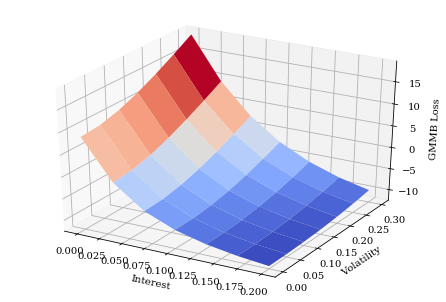

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

interest1 = np.linspace(0, 0.2, num=7)
vol1 = np.linspace(0, 0.3, num=7)
interest1, vol1 = np.meshgrid(interest1, vol1)
v = np.zeros_like(interest1)

for i in range(7): 
    for j in range(7):
        interest = [interest1[i, j], r[1]]
        vol = [vol1[i, j], sigma[1]]
        v[i, j] = rsmjd_gmmb_fst(S0, G, T, interest, vol, m, me, lamb, mu, nu, A, Pi, N, X)

surf = ax.plot_surface(interest1, vol1, v, cmap=plt.cm.coolwarm)
ax.set_xlabel('Interest')
ax.set_ylabel('Volatility')
ax.set_zlabel('GMMB Loss') 
plt.show()

## Fair rates

0.01651366493609785

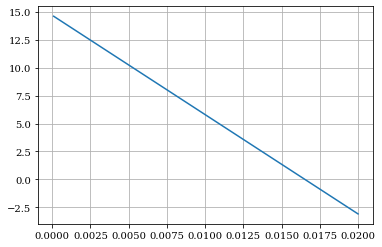

In [10]:
# Fair Rates (m, me)
me = np.linspace(0.0001, 0.02)
loss = []
for i in me:
    temp = rsmjd_gmmb_fst(S0, G, T, r, sigma, m, i, lamb, mu, nu, A, Pi, N, X)
    loss.append(temp)
plt.plot(me, loss)
plt.grid()
f = interpolate.PchipInterpolator(loss[::-1], me[::-1])
me = f(0) # fair rate of me
float(me) # 0.01651366493609785

In [12]:
## Delta

In [9]:
def rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    delta_p1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST)).real
    delta_p2 = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, delta_p1)
    f2 = interpolate.PchipInterpolator(ST, delta_p2)
    Delta_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Delta_P) # -0.2892064937563866
print('Delta_Put = %.16f' % rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Delta_Put = -0.2851798089966586


In [10]:
def rsmjd_gmmbdelta_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Delta_P = rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Delta_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        delta_re1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        delta_re2 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, delta_re1)
        f2 = interpolate.PchipInterpolator(ST, delta_re2)
        Delta_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Delta = s(T) * Delta_P - np.sum(Delta_Re)
    return float(Delta) # -0.4162717019499024
print('Delta_GMMB = %.16f' % rsmjd_gmmbdelta_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))

Delta_GMMB = -0.4162717019499024


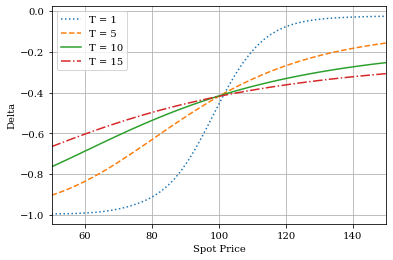

In [11]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsmjd_gmmbdelta_fst(i, G, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Delta')
# plt.ylim((-1, 0))
plt.grid()

## Gamma

In [13]:
def rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    gamma_p1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST ** 2)).real
    gamma_p2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST ** 2)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, gamma_p1)
    f2 = interpolate.PchipInterpolator(ST, gamma_p2)
    Gamma_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Gamma_P) # 0.0062255454081478
print('Gamma_Put = %.16f' % rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Gamma_Put = 0.0055049515372804


In [14]:
def rsmjd_gmmbgamma_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Gamma_P = rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Gamma_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        gamma_re1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST ** 2)).real
        gamma_re2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)) / (ST ** 2)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, gamma_re1)
        f2 = interpolate.PchipInterpolator(ST, gamma_re2)
        Gamma_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB delta
    Gamma = s(T) * Gamma_P - np.sum(Gamma_Re)
    return float(Gamma) # 0.0060459769788203
print('Gamma_GMMB = %.16f' % rsmjd_gmmbgamma_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))

Gamma_GMMB = 0.0054177473770854


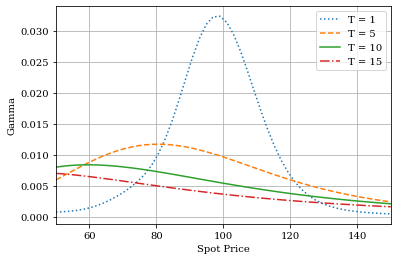

In [15]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsmjd_gmmbgamma_fst(i, G, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Gamma')
# plt.ylim((0, 0.035))
plt.grid()

## Rho

In [16]:
def rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for rho 1
    rho1_p1 = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    rho1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho1_p1)
    f2 = interpolate.PchipInterpolator(ST, rho1_p2)
    Rho1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for rho 2
    rho2_p1 = ifft(0 * fft(payoff_p)).real
    rho2_p2 = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho2_p1)
    f2 = interpolate.PchipInterpolator(ST, rho2_p2)
    Rho2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Rho1_P), float(Rho2_P))
Results = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
print('Rho1_Put = %.16f' % Results[0]) # -4.2758786616469537
print('Rho2_Put = %.16f' % Results[1]) # -0.0004827956080686

Rho1_Put = -4.4371758355264328
Rho2_Put = -0.0004939428560587


In [19]:
def rsmjd_gmmbrho_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Rho1_P = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Rho2_P = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Rho1_Re = []
    Rho2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        rho1_re1 = ifft((1j * w - 1) * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        rho1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho1_re1)
        f2 = interpolate.PchipInterpolator(ST, rho1_re2)
        Rho1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        rho2_re1 = ifft(0 * fft(payoff_r)).real
        rho2_re2 = ifft((1j * w - 1) * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho2_re1)
        f2 = interpolate.PchipInterpolator(ST, rho2_re2)
        Rho2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Rho1_Re = np.sum(Rho1_Re) / 100
    Rho2_Re = np.sum(Rho2_Re) / 100
    # calculate GMMB delta
    Rho1 = (s(T) * Rho1_P - Rho1_Re)
    Rho2 = (s(T) * Rho2_P - Rho2_Re)
    return (float(Rho1), float(Rho2))
Results = rsmjd_gmmbrho_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Rho1_GMMB = %.16f' % Results[0]) # -3.9644445280816925
print('Rho2_GMMB = %.16f' % Results[1]) # -0.0004476311322287

Rho1_GMMB = -4.1139936030170290
Rho2_GMMB = -0.0004579664690787


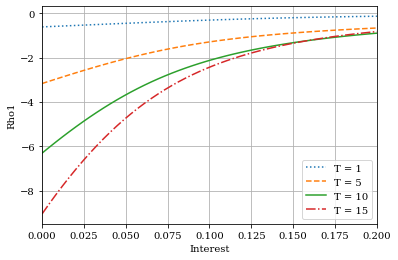

In [20]:
rho1 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in rho1:
        interest = [i, r[1]]
        temp = rsmjd_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(rho1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho1')
plt.grid()

## Vega

In [21]:
def rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    vega1_p1 = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    vega1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega1_p1)
    f2 = interpolate.PchipInterpolator(ST, vega1_p2)
    Vega1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    vega2_p1 = ifft(0 * fft(payoff_p)).real
    vega2_p2 = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega2_p1)
    f2 = interpolate.PchipInterpolator(ST, vega2_p2)
    Vega2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Vega1_P), float(Vega2_P))
Results = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Vega1_Put = %.16f' % Results[0]) # 0.6225024163399533
print('Vega2_Put = %.16f' % Results[1]) # 0.0001175009773657

Vega1_Put = 0.5504435468784196
Vega2_Put = 0.0001043104931637


In [22]:
def rsmjd_gmmbvega_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Vega1_P = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Vega2_P = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Vega1_Re = []
    Vega2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        vega1_re1 = ifft(-(1j * w + w ** 2) * sigma1 * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        vega1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega1_re1)
        f2 = interpolate.PchipInterpolator(ST, vega1_re2)
        Vega1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))           # FST method for sigma2
        vega2_re1 = ifft(0 * fft(payoff_r)).real
        vega2_re2 = ifft(-(1j * w + w ** 2) * sigma2 * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega2_re1)
        f2 = interpolate.PchipInterpolator(ST, vega2_re2)
        Vega2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Vega1_Re = np.sum(Vega1_Re) / 100
    Vega2_Re = np.sum(Vega2_Re) / 100
    # calculate GMMB delta
    Vega1 = (s(T) * Vega1_P - Vega1_Re)
    Vega2 = (s(T) * Vega2_P - Vega2_Re)
    return (float(Vega1), float(Vega2))
Results = rsmjd_gmmbvega_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Vega1_GMMB = %.16f' % Results[0]) # 0.5771623784058360
print('Vega2_GMMB = %.16f' % Results[1]) # 0.0001089427796280

Vega1_GMMB = 0.5103519253169398
Vega2_GMMB = 0.0000967130259199


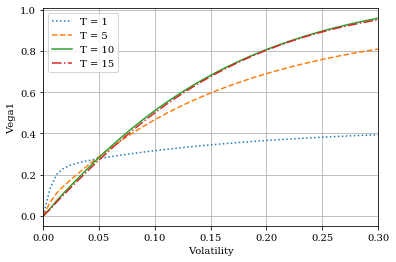

In [23]:
vol1 = np.linspace(0, 0.3)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in vol1:
        vol = [i, sigma[1]]
        temp = rsmjd_gmmbvega_fst(S0, G, time[j], r, vol, m, me, lamb, mu, nu, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(vol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.3))
plt.ylabel('Vega1')
plt.grid()

## Lamb

In [25]:
def rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    lamb1_p1 = ifft((-1j * w * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) + np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    lamb1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, lamb1_p1)
    f2 = interpolate.PchipInterpolator(ST, lamb1_p2)
    Lamb1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    lamb2_p1 = ifft(0 * fft(payoff_p)).real
    lamb2_p2 = ifft((-1j * w * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) + np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, lamb2_p1)
    f2 = interpolate.PchipInterpolator(ST, lamb2_p2)
    Lamb2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Lamb1_P), float(Lamb2_P))
Results = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Lamb1_Put = %.16f' % Results[0]) # 0.6225024163399533
print('Lamb2_Put = %.16f' % Results[1]) # 0.0001175009773657

Lamb1_Put = 0.1511416152160739
Lamb2_Put = 0.0000113090485018


In [29]:
def rsmjd_gmmblamb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Lamb1_P = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Lamb2_P = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Lamb1_Re = []
    Lamb2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        lamb1_re1 = ifft((-1j * w * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) + np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        lamb1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, lamb1_re1)
        f2 = interpolate.PchipInterpolator(ST, lamb1_re2)
        Lamb1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        lamb2_re1 = ifft(0 * fft(payoff_r)).real
        lamb2_re2 = ifft((-1j * w * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) + np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, lamb2_re1)
        f2 = interpolate.PchipInterpolator(ST, lamb2_re2)
        Lamb2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Lamb1_Re = np.sum(Lamb1_Re) / 100
    Lamb2_Re = np.sum(Lamb2_Re) / 100
    # calculate GMMB delta
    Lamb1 = (s(T) * Lamb1_P - Lamb1_Re)
    Lamb2 = (s(T) * Lamb2_P - Lamb2_Re)
    return (float(Lamb1), float(Lamb2))
Results = rsmjd_gmmblamb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Lamb1_GMMB = %.16f' % Results[0]) # 0.5771623784058360
print('Lamb2_GMMB = %.16f' % Results[1]) # 0.0001089427796280

Lamb1_GMMB = 0.1511538958955666
Lamb2_GMMB = 0.0000101129117496


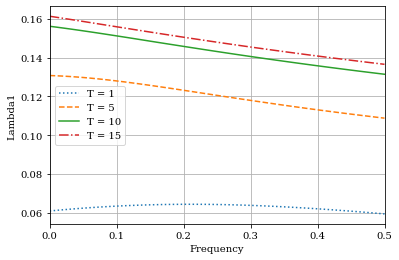

In [42]:
freq1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in freq1:
        freq = [i, lamb[1]]
        temp = rsmjd_gmmblamb_fst(S0, G, time[j], r, sigma, m, me, freq, mu, nu, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(freq1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Frequency')
plt.xlim((0, 0.5))
plt.ylabel('Lambda1')
plt.grid()

## Mu

In [32]:
def rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    mu1_p1 = ifft((-1j * w * lamb1 * np.exp(mu1 + 0.5 * nu1 ** 2) + j * w * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    mu1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, mu1_p1)
    f2 = interpolate.PchipInterpolator(ST, mu1_p2)
    Mu1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    mu2_p1 = ifft(0 * fft(payoff_p)).real
    mu2_p2 = ifft((-1j * w * lamb2 * np.exp(mu2 + 0.5 * nu2 ** 2) + j * w * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, mu2_p1)
    f2 = interpolate.PchipInterpolator(ST, mu2_p2)
    Mu2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Mu1_P), float(Mu2_P))
Results = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Mu1_Put = %.16f' % Results[0]) # 0.6225024163399533
print('Mu2_Put = %.16f' % Results[1]) # 0.0001175009773657

Mu1_Put = 0.3500282087787155
Mu2_Put = 0.0000558894158853


In [35]:
def rsmjd_gmmbmu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Mu1_P = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Mu2_P = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu1_Re = []
    Mu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        mu1_re1 = ifft((-1j * w * lamb1 * np.exp(mu1 + 0.5 * nu1 ** 2) + j * w * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        mu1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu1_re1)
        f2 = interpolate.PchipInterpolator(ST, mu1_re2)
        Mu1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        mu2_re1 = ifft(0 * fft(payoff_r)).real
        mu2_re2 = ifft((-1j * w * lamb2 * np.exp(mu2 + 0.5 * nu2 ** 2) + j * w * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu2_re1)
        f2 = interpolate.PchipInterpolator(ST, mu2_re2)
        Mu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Mu1_Re = np.sum(Mu1_Re) / 100
    Mu2_Re = np.sum(Mu2_Re) / 100
    # calculate GMMB delta
    Mu1 = (s(T) * Mu1_P - Mu1_Re)
    Mu2 = (s(T) * Mu2_P - Mu2_Re)
    return (float(Mu1), float(Mu2))
Results = rsmjd_gmmbmu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Mu1_GMMB = %.16f' % Results[0]) # 0.5771623784058360
print('Mu2_GMMB = %.16f' % Results[1]) # 0.0001089427796280

Mu1_GMMB = 0.5110255957554036
Mu2_GMMB = 0.0000798703971249


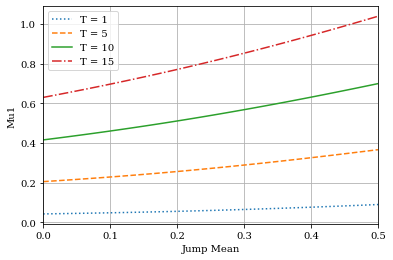

In [41]:
jmean1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in jmean1:
        jmean = [i, mu[1]]
        temp = rsmjd_gmmbmu_fst(S0, G, time[j], r, sigma, m, me, lamb, jmean, nu, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(jmean1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Jump Mean')
plt.xlim((0, 0.5))
plt.ylabel('Mu1')
plt.grid()

## nu

In [37]:
def rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    nu1_p1 = ifft((-1j * w * lamb1 * nu1 * np.exp(mu1 + 0.5 * nu1 ** 2) - nu1 * w ** 2 * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    nu1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, nu1_p1)
    f2 = interpolate.PchipInterpolator(ST, nu1_p2)
    Nu1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    nu2_p1 = ifft(0 * fft(payoff_p)).real
    nu2_p2 = ifft((-1j * w * lamb2 * nu2 * np.exp(mu2 + 0.5 * nu2 ** 2) - nu2 * w ** 2 * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, nu2_p1)
    f2 = interpolate.PchipInterpolator(ST, nu2_p2)
    Nu2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Nu1_P), float(Nu2_P))
Results = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Nu1_Put = %.16f' % Results[0]) # 0.6225024163399533
print('Nu2_Put = %.16f' % Results[1]) # 0.0001175009773657

Nu1_Put = 0.0653933630392800
Nu2_Put = 0.0000174966186302


In [38]:
def rsmjd_gmmbnu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Nu1_P = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Nu2_P = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Nu1_Re = []
    Nu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        nu1_re1 = ifft((-1j * w * lamb1 * nu1 * np.exp(mu1 + 0.5 * nu1 ** 2) - nu1 * w ** 2 * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        nu1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, nu1_re1)
        f2 = interpolate.PchipInterpolator(ST, nu1_re2)
        Nu1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        nu2_re1 = ifft(0 * fft(payoff_r)).real
        nu2_re2 = ifft((-1j * w * lamb2 * nu2 * np.exp(mu2 + 0.5 * nu2 ** 2) - nu2 * w ** 2 * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, nu2_re1)
        f2 = interpolate.PchipInterpolator(ST, nu2_re2)
        Nu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Nu1_Re = np.sum(Nu1_Re) / 100
    Nu2_Re = np.sum(Nu2_Re) / 100
    # calculate GMMB delta
    Nu1 = (s(T) * Nu1_P - Nu1_Re)
    Nu2 = (s(T) * Nu2_P - Nu2_Re)
    return (float(Nu1), float(Nu2))
Results = rsmjd_gmmbnu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Nu1_GMMB = %.16f' % Results[0]) # 0.5771623784058360
print('Nu2_GMMB = %.16f' % Results[1]) # 0.0001089427796280

Nu1_GMMB = 0.0612250095375586
Nu2_GMMB = 0.0000164011212354


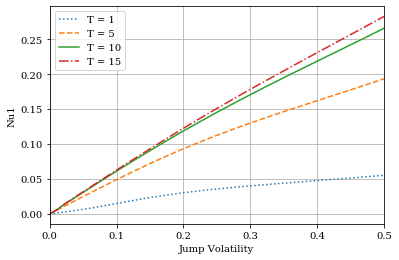

In [40]:
jvol1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in jvol1:
        jvol = [i, nu[1]]
        temp = rsmjd_gmmbnu_fst(S0, G, time[j], r, sigma, m, me, lamb, mu, jvol, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(jvol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Jump Volatility')
plt.xlim((0, 0.5))
plt.ylabel('Nu1')
plt.grid()